In [ ]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define constants and create tensors on the GPU
N_point = 22500
N_t = 77
L_left = 0
L_right = 4380
nx = ny = 150

U_total = torch.zeros((N_point * N_t, 1), dtype=torch.float32, device=device)
X_total = torch.zeros((N_point * N_t, 1), dtype=torch.float32, device=device)
Y_total = torch.zeros((N_point * N_t, 1), dtype=torch.float32, device=device)

# Populate X_total and Y_total with grid values
for i in range(N_t):
    x = np.linspace(L_left, L_right, nx)
    y = np.linspace(L_left, L_right, ny)
    X, Y = np.meshgrid(x, y)
    X_total[i * N_point : (i + 1) * N_point] = torch.tensor(X.reshape(N_point, 1), dtype=torch.float32, device=device)
    Y_total[i * N_point : (i + 1) * N_point] = torch.tensor(Y.reshape(N_point, 1), dtype=torch.float32, device=device)

# Load and preprocess U_total from the .mat file
U = sio.loadmat('U_total_1')
data = list(U.items())[3][1]
U_data = data[0:N_point * N_t, 0]
U_total = torch.tensor(U_data, dtype=torch.float32, device=device).view(-1, 1).requires_grad_(True)
U_xy1 = torch.cat((X_total, Y_total, U_total), dim=1)
sio.savemat('U_xy1.mat', {'U_xy1': U_xy1.cpu().detach().numpy()})  # Save to .mat on CPU


# Define the fully connected neural network (FCN)
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())
        self.fch = nn.Sequential(
            *[nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()) for _ in range(N_LAYERS - 1)]
        )
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Initialize network and parameters
torch.manual_seed(123)
pinn = FCN(3, 1, 20, 3).to(device)

# Create time tensor on the GPU
dt = 1 / 3
t_total = torch.zeros((N_point * N_t, 1), dtype=torch.float32, device=device)
for i in range(N_t):
    T = (i + 1) * dt + 0.001
    t_step = (torch.ones((N_point, 1), dtype=torch.float32, device=device) * T).view(-1, 1)
    t_total[i * N_point : (i + 1) * N_point] = t_step
t_total = t_total.requires_grad_(True)

# Load input data from 'U_xy1.mat' on the GPU
x_data = sio.loadmat('U_xy1')
data = list(x_data.items())[3][1]
x_d = torch.tensor(data[0:N_point * N_t, 0], dtype=torch.float32, device=device).view(-1, 1).requires_grad_(True)
y_d = torch.tensor(data[0:N_point * N_t, 1], dtype=torch.float32, device=device).view(-1, 1).requires_grad_(True)
u_d = torch.tensor(data[0:N_point * N_t, 2], dtype=torch.float32, device=device).view(-1, 1).requires_grad_(True)

# Normalize data
def normalize(data, data_min, data_max):
    return (data - data_min) / (data_max - data_min)

def denormalize(data, data_min, data_max):
    return data * (data_max - data_min) + data_min

x_d_min, x_d_max = torch.min(x_d), torch.max(x_d)
y_d_min, y_d_max = torch.min(y_d), torch.max(y_d)
u_d_min, u_d_max = torch.min(u_d), torch.max(u_d)

x_d_normalized = normalize(x_d, x_d_min, x_d_max)
y_d_normalized = normalize(y_d, y_d_min, y_d_max)
u_d_normalized = normalize(u_d, u_d_min, u_d_max)

X_d = torch.cat([t_total, x_d_normalized, y_d_normalized], dim=1)
u_exact = u_d_normalized

# Define learnable parameters and optimizer
D_0 = torch.nn.Parameter(torch.ones(1, device=device, requires_grad=True) * np.log(1.3))
r = torch.nn.Parameter(torch.ones(1, device=device, requires_grad=True) * np.log(3))
K = torch.nn.Parameter(torch.ones(1, device=device, requires_grad=True) * np.log(2.6))
gama = torch.nn.Parameter(torch.ones(1, device=device, requires_grad=True) * np.log(1.5))

optimizer = torch.optim.Adam(list(pinn.parameters()) + [D_0, r, K, gama], lr=1e-3)

# Store parameter values at each iteration
D_0_history, r_history, K_history, gama_history= [], [], [], []
min_loss = float('inf')
best_params = {}
# Training loop
for i in range(10001):
    optimizer.zero_grad()

    # Hyper parameters
    lambda1, lambda2 = 1e-3, 1

    # Compute the PINN loss terms
    u = pinn(X_d)
    u_t = torch.autograd.grad(u, t_total, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_d_normalized, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_d_normalized, torch.ones_like(u_x), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y_d_normalized, torch.ones_like(u), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y_d_normalized, torch.ones_like(u_y), create_graph=True)[0]

    exp_D_0, exp_r, exp_K, exp_gama = torch.exp(D_0), torch.exp(r), torch.exp(K), torch.exp(gama)

    # Physics-based loss
    loss1 = torch.mean(
        (u_t - exp_D_0 * 1000 * (u_xx + u_yy) - exp_r * 0.1 * u * torch.abs(1 - u / (exp_K * 1000)) ** exp_gama * torch.sign(1 - u / (exp_K * 1000))) ** 2
    )

    # Data-based loss
    loss2 = torch.mean((u - u_exact) ** 2)

    # Joint loss and backpropagation
    loss = lambda1 * loss1 + lambda2 * loss2
    loss.backward(retain_graph=True)
    optimizer.step()

    # Save parameter values
    D_0_history.append(torch.exp(D_0).item() * 1000)
    r_history.append(torch.exp(r).item() * 0.1)
    K_history.append(torch.exp(K).item() * 1000)
    gama_history.append(torch.exp(gama).item())
    # Update best parameters if current loss is the smallest
    if loss.item() < min_loss:
        min_loss = loss.item()
        best_params = {
            "D_0": torch.exp(D_0).item() * 1000,
            "r": torch.exp(r).item() * 0.1,
            "K": torch.exp(K).item() * 1000,
            "gama": torch.exp(gama).item()
        }

    # Log progress every 100 iterations
    if i % 100 == 0:
        print(f"Step {i}: Loss = {loss.item()}, D_0 = {D_0_history[-1]}, r = {r_history[-1]}, K = {K_history[-1]}, gama = {gama_history[-1]}")

# Print best parameters at minimum loss
print("Best parameters at minimum loss:")
print(best_params)


Step 0: Loss = 0.38214409351348877, D_0 = 1298.7005710601807, r = 0.30030012130737305, K = 2598.5310077667236, gama = 1.5008479356765747
Step 100: Loss = 0.03964568302035332, D_0 = 1270.2995538711548, r = 0.307674241065979, K = 2630.3462982177734, gama = 1.4826948642730713
Step 200: Loss = 0.03858372941613197, D_0 = 1268.232822418213, r = 0.31605761051177983, K = 2657.841205596924, gama = 1.4673577547073364
Step 300: Loss = 0.03806109353899956, D_0 = 1266.7123079299927, r = 0.32169055938720703, K = 2672.9254722595215, gama = 1.4590774774551392
Step 400: Loss = 0.03769708797335625, D_0 = 1265.4900550842285, r = 0.3253431081771851, K = 2681.095838546753, gama = 1.4546308517456055
Step 500: Loss = 0.0373905673623085, D_0 = 1264.6293640136719, r = 0.32891995906829835, K = 2688.2545948028564, gama = 1.4507572650909424
Step 600: Loss = 0.03713914006948471, D_0 = 1263.9245986938477, r = 0.3329999923706055, K = 2695.98650932312, gama = 1.4465967416763306
Step 700: Loss = 0.03695287927985191, D

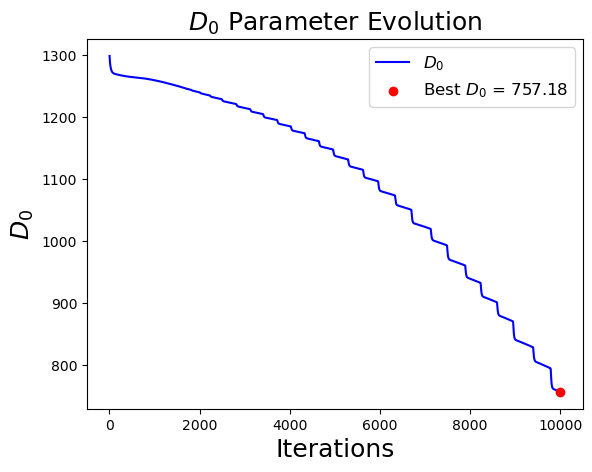

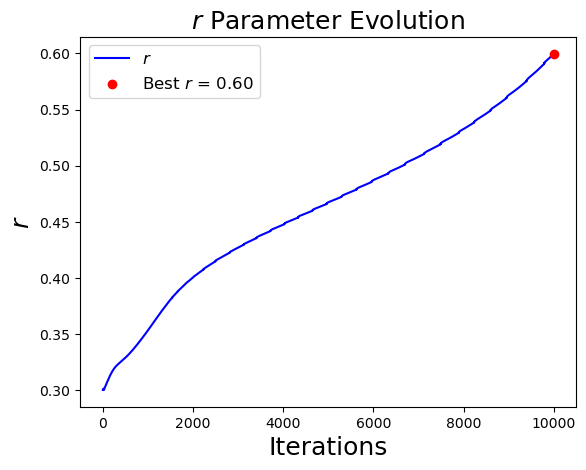

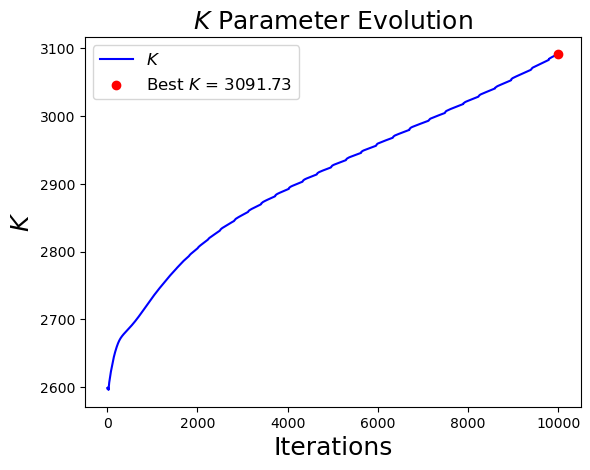

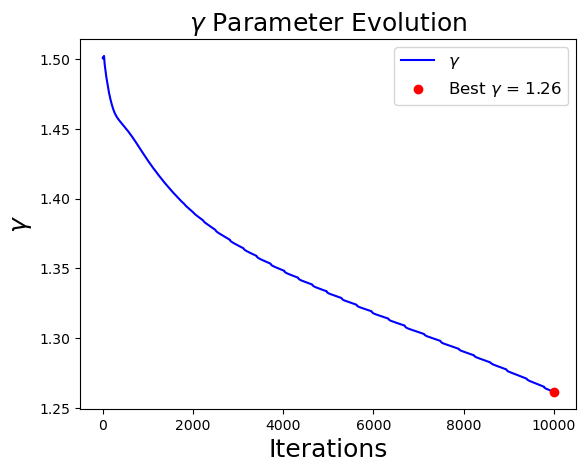

In [ ]:
# Create a range for iterations
iterations = list(range(1, len(D_0_history) + 1))

# Plot D_0
plt.plot(iterations, D_0_history, label="$D_0$", color="blue")
plt.scatter(iterations[D_0_history.index(best_params["D_0"])], best_params["D_0"],
            color="red", label=f"Best $D_0$ = {best_params['D_0']:.2f}", zorder=5)
plt.title("$D_0$ Parameter Evolution", fontsize=18)
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("$D_0$", fontsize=18)
plt.legend(fontsize = 'large')
plt.savefig("D0_1_Richards.pdf", format='pdf')
plt.show()

# Plot r
plt.plot(iterations, r_history, label="$r$", color="blue")
plt.scatter(iterations[r_history.index(best_params["r"])], best_params["r"],
            color="red", label=f"Best $r$ = {best_params['r']:.2f}", zorder=5)
plt.title("$r$ Parameter Evolution", fontsize=18)
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("$r$", fontsize=18)
plt.legend(fontsize = 'large')
plt.savefig("r_1_Richardsr.pdf", format='pdf')
plt.show()


# Plot K
plt.plot(iterations, K_history, label="$K$", color="blue")
plt.scatter(iterations[K_history.index(best_params["K"])], best_params["K"],
            color="red", label=f"Best $K$ = {best_params['K']:.2f}", zorder=5)
plt.title("$K$ Parameter Evolution", fontsize=18)
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("$K$", fontsize=18)
plt.legend(fontsize = 'large')
plt.savefig("K_1_Richards.pdf", format='pdf')
plt.show()

# Plot gama
plt.plot(iterations, gama_history, label="$\\gamma$", color="blue")
plt.scatter(iterations[gama_history.index(best_params["gama"])], best_params["gama"],
            color="red", label=f"Best $\\gamma$ = {best_params['gama']:.2f}", zorder=5)
plt.title("$\\gamma$ Parameter Evolution", fontsize=18)
plt.xlabel("Iterations", fontsize=18)
plt.ylabel("$\\gamma$", fontsize=18)
plt.legend(fontsize = 'large')
plt.savefig("gama_1_Richards.pdf", format='pdf')
plt.show()